# Multi-compound biplot

In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

import shnitsel as sh
import shnitsel.xarray

from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

## Load molecules

In [2]:
# This tutorial follows after walkthroughs/2_pca_across_compounds.ipynb
# Please run that notebook first to obtain homologs.nc

homologs = sh.open_frames('/tmp/homologs.nc')
homologs

<xarray.Dataset> Size: 340MB
Dimensions:    (state: 3, frame: 53332, direction: 3, statecomb: 3, atom: 6,
                trajid_: 255)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
  * trajid_    (trajid_) int32 1kB 2 3 6 13 17 19 20 ... 938 944 947 954 961 969
    atNames    (frame, atom) <U1 1MB ...
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
  * frame      (frame) object 427kB MultiIndex
  * cmpnd      (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid     (frame) int64 427kB 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time       (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Data variables: (12/13)
    energy     (state, frame) float64 1MB ...
    dip_perm   (state, direction, frame) float64 4MB ...
    dip_trans  (statecomb, direction, frame) float64 4MB ...
    sdiag      (frame) int64 427kB ...
    astate     (frame) int64 427kB ...
    forces     (state, atom, direction, frame) float64 23MB ...
    ...         ...
    nacs       (statecomb, atom, direction, frame) float64 23MB ...
    atXYZ      (atom, direction, frame) float64 8MB ...
    max_ts     (trajid_, frame) float64 109MB ...
    completed  (trajid_, frame) float32 54MB ...
    nsteps     (trajid_, frame) float64 109MB ...
    e_kin      (frame) float64 427kB ...
Attributes:
    delta_t:  0.5

## Pairwise distance PCA fitted over all analogical compounds

In [3]:
pca = homologs.atXYZ.sh.pairwise_dists_pca()
pca

<xarray.DataArray (frame: 53332, PC: 2)> Size: 853kB
array([[-0.49254555, -0.18807667],
       [-0.4943486 , -0.16643753],
       [-0.48172495, -0.14110762],
       ...,
       [ 0.53443245, -0.07225063],
       [ 0.53119398, -0.08579228],
       [ 0.52652913, -0.0981503 ]], shape=(53332, 2))
Coordinates:
  * frame    (frame) object 427kB MultiIndex
  * cmpnd    (frame) <U3 640kB 'I01' 'I01' 'I01' 'I01' ... 'A03' 'A03' 'A03'
  * trajid   (frame) int64 427kB 2 2 2 2 2 2 2 2 ... 316 316 316 316 316 316 316
  * time     (frame) float64 427kB 0.0 0.5 1.0 1.5 2.0 ... 76.5 77.0 77.5 78.0
Dimensions without coordinates: PC

Text(0.02, 0.5, 'PC2')

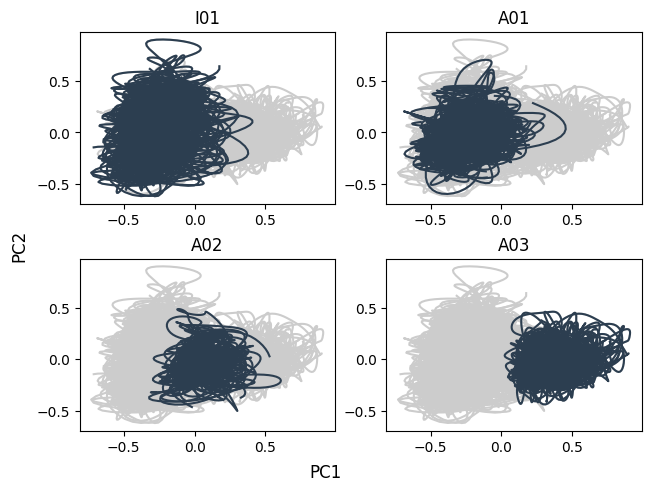

In [4]:
fig, axs = plt.subplot_mosaic([['I01', 'A01'],['A02', 'A03']], layout='constrained')

for name, ax in axs.items():
    ax.set_title(name)
    for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
        axs[cmpnd].plot(traj[:,0], traj[:,1], c='#2c3e50')

fig.supxlabel('PC1')
fig.supylabel('PC2')

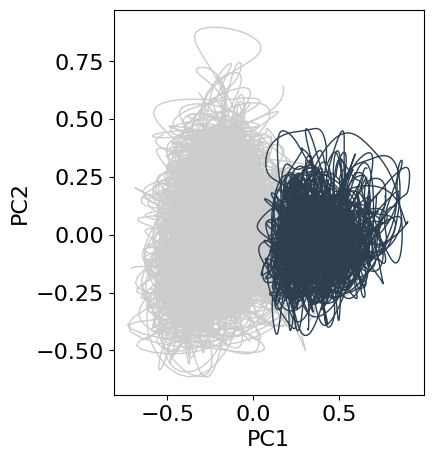

In [6]:
plt.rc('font', size=16)
plt.rc('lines', linewidth=1)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(4, 5)
for (cmpnd, trajid), traj in pca.sh.mgroupby(['cmpnd', 'trajid']):
    if cmpnd == 'A03':
        ax.plot(traj[:,0], traj[:,1], c='#2c3e50', zorder=10)
    else:
        ax.plot(traj[:,0], traj[:,1], c='#ccc')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
fig.savefig('/nc/reports/2025-06-30_4-step_figure/2.pdf')

## Biplot of pairwise-distance PCA fitted to all analogs

sweeping clock from -25°
swept to -65°
sweeping anti from 25°
swept to 55°


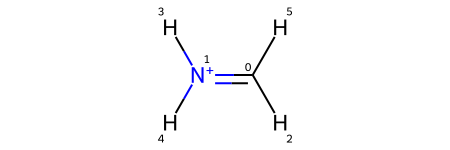

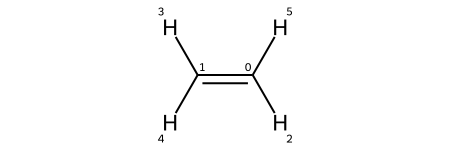

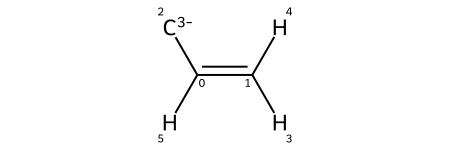

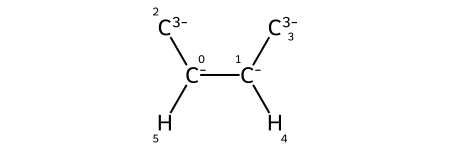

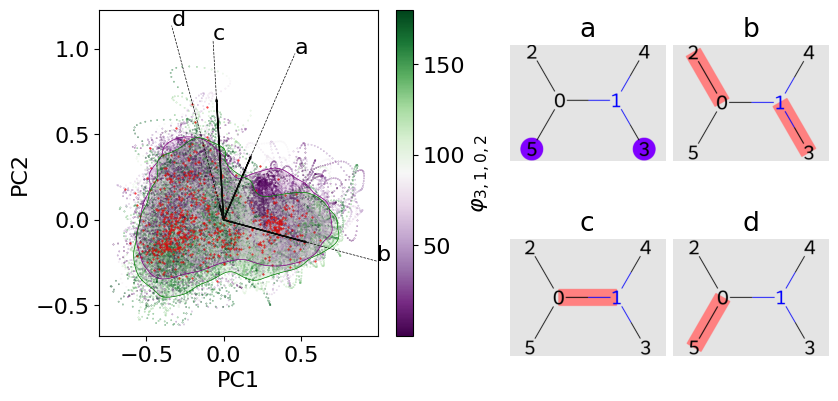

In [8]:
sh.plot.biplot_kde(homologs, 3, 1, 0, 2, scatter_color='geo')
display(homologs.atXYZ.sel(cmpnd='I01').isel(frame=0).sh.to_mol(+1,to2D=True))
display(homologs.atXYZ.sel(cmpnd='A01').isel(frame=0).sh.to_mol(to2D=True))
display(homologs.atXYZ.sel(cmpnd='A02').isel(frame=0).sh.to_mol(-3,to2D=True))
display(homologs.atXYZ.sel(cmpnd='A03').isel(frame=0).sh.to_mol(-8,to2D=True))

The next plot is somewhat redundant, but illustrates how to colour a PCA by dihedral directly:

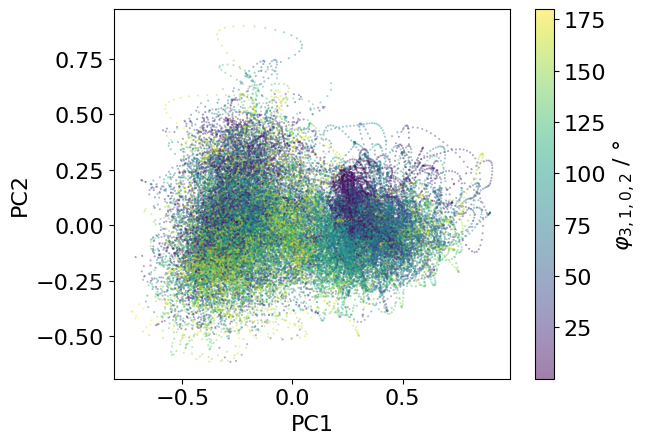

In [9]:
pca = homologs.atXYZ.sh.pairwise_dists_pca()
dih = homologs.atXYZ.sh.dihedral(3, 1, 0, 2, deg=True)
pca['dih'] = dih
plt.scatter(pca[:, 0], pca[:, 1], c=pca['dih'], s=0.2, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label=dih.attrs['long_name'] + ' / °')